In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# This is the library for the Reservoir Computing got it by: https://github.com/cknd/pyESN
import sys
sys.path.append('..')

from pyESN import ESN 
from tp_utils import daily_returns
from tp_config import *

In [2]:
data_path = DATA_PATH_SHARES
asset = 'sber.me'
df = pd.read_csv(data_path + '/' + asset.upper() +'.csv')
  
data = pd.DataFrame(df['Adj Close'])
data['Returns'] = np.log(data / data.shift())  
data.dropna(inplace=True)
pclose = df['Adj Close'].values

In [4]:
#Overall profit for one contract trades
def asset_ideal_long_profit(data):
    """ profit per asset for long only trades
    data: close prices
    """
    x = np.diff(data)
    res = x[x > 0].sum()
    return res

asset_ideal_long_profit(pclose)

1876.2050552368164

## Test SVM gaussian

In [120]:
lags = 14

cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = np.sign(data['Returns'].shift(lag))  
    cols.append(col)
data.dropna(inplace=True)

In [123]:
from sklearn.svm import SVC
model = SVC(gamma='scale')  
test = 300  
model.fit(data.iloc[:-test][cols], np.sign(data.iloc[:-test]['Returns']))  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

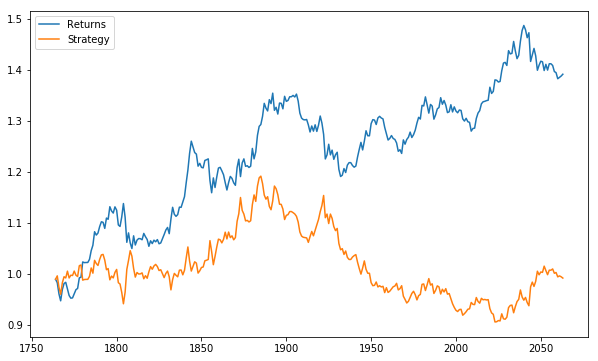

In [124]:
data['Prediction'] = model.predict(data[cols])  
data['Strategy'] = data['Prediction'] * data['Returns']  

data.iloc[-test:][['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));  

In [72]:
data

,Adj Close,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Prediction,Strategy
7,64.355659,0.058443,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.058443
8,64.465904,0.001712,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,0.001712
9,65.789032,0.020317,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,0.020317
10,66.105118,0.004793,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-0.004793
11,63.142769,-0.045848,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-0.045848
...,...,...,...,...,...,...,...,...,...,...
2059,251.360001,-0.001550,-1.0,-1.0,0.0,1.0,-1.0,1.0,-1.0,0.001550
2060,249.199997,-0.008630,-1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,-0.008630
2061,249.699997,0.002004,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,0.002004
2062,250.149994,0.001801,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,0.001801


## Test Echo State Networks

In [5]:
n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.2
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)


In [6]:
trainlen = 200
future = 2
futureTotal=100
pred_tot=np.zeros(futureTotal)

In [60]:

trainlenSVM = trainlen-futureTotal

X_train = np.zeros([futureTotal, trainlenSVM])
for i in range(futureTotal):
    X_train[i, : ] = data[i:trainlenSVM+i]
    
X_test = np.zeros([futureTotal, trainlenSVM])
for i in range(futureTotal):
    X_test[i, : ] = data[futureTotal + i:trainlen + i]
    
y_train = data[trainlenSVM:trainlenSVM + futureTotal]
y_test = data[trainlen:trainlen + futureTotal]

clf = SVC(gamma='scale')  
model = clf.fit(X_train, y_train)
model.predict(X_test)

ValueError: could not broadcast input array from shape (100,2) into shape (100)

In [8]:
#%%time

for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen), data[i:trainlen + i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0] 

TypeError: '(0, slice(None, None, None))' is an invalid key

In [7]:
%load_ext line_profiler

In [8]:
%lprun -f esn.fit esn.fit(np.ones(trainlen), data[i:trainlen + i])

Timer unit: 1e-06 s

Total time: 0.129308 s
File: /home/teslauser/quant/tp/pyESN.py
Function: fit at line 160

Line #      Hits         Time  Per Hit   % Time  Line Contents
   160                                               def fit(self, inputs, outputs, inspect=False):
   161                                                   """
   162                                                   Collect the network's reaction to training data, train readout weights.
   163                                           
   164                                                   Args:
   165                                                       inputs: array of dimensions (N_training_samples x n_inputs)
   166                                                       outputs: array of dimension (N_training_samples x n_outputs)
   167                                                       inspect: show a visualisation of the collected reservoir states
   168                                           
   16

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef as MCC
signals = np.sign(pred_tot).astype(int)
real_data = data[0:100]
bin_real_data = np.sign(real_data).astype(int)
bin_real_data[0] = 1
cm = confusion_matrix(bin_real_data, signals)

balance = np.mean(bin_real_data == 1)
acc = accuracy_score(bin_real_data, signals)
mcc = MCC(bin_real_data, signals)

print(balance, acc, mcc)

0.49 0.58 0.15911844096181874


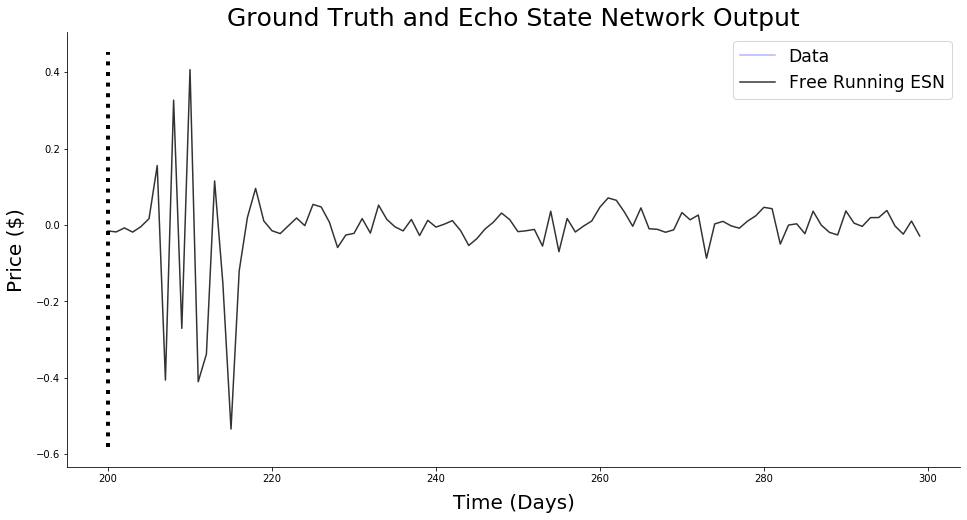

In [14]:
plt.figure(figsize=(16,8))
plt.plot(range(1000,trainlen+futureTotal),data[1000:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()

In [15]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

In [16]:
n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23
radius_set = [0.9,  1,  1.1]
noise_set = [ 0.001, 0.004, 0.006]

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 200
future = 2
futureTotal= 100

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho,
          noise=noise)

        for i in range(0,futureTotal,future):
            pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
            prediction = esn.predict(np.ones(future))
            pred_tot[i:i+future] = prediction[:,0]
        
        loss[l, j] = MSE(pred_tot, data[trainlen:trainlen+futureTotal])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )

rho =  0.5 , noise =  0.0001 , MSE =  0.07272547732322314
rho =  0.5 , noise =  0.0003 , MSE =  0.06147824012131924
rho =  0.5 , noise =  0.0007 , MSE =  0.05740440280855033
rho =  0.5 , noise =  0.001 , MSE =  0.05577151808240103
rho =  0.5 , noise =  0.003 , MSE =  0.04856719028124351
rho =  0.5 , noise =  0.005 , MSE =  0.04611805818914189
rho =  0.5 , noise =  0.007 , MSE =  0.04513569747751639
rho =  0.5 , noise =  0.01 , MSE =  0.04468073185913075
rho =  0.7 , noise =  0.0001 , MSE =  0.05446616452738033
rho =  0.7 , noise =  0.0003 , MSE =  0.06379493266260734
rho =  0.7 , noise =  0.0007 , MSE =  0.0683914796740243
rho =  0.7 , noise =  0.001 , MSE =  0.06724742085788264
rho =  0.7 , noise =  0.003 , MSE =  0.05661155512545829
rho =  0.7 , noise =  0.005 , MSE =  0.051796458466688906
rho =  0.7 , noise =  0.007 , MSE =  0.04925957630999052
rho =  0.7 , noise =  0.01 , MSE =  0.04726891111267528
rho =  0.9 , noise =  0.0001 , MSE =  0.2027432780486261
rho =  0.9 , noise =  0.000

In [ ]:
plt.figure(figsize=(16,8))
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuRd')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 

# im.set_interpolation('bilinear')
cb = plt.colorbar(im);

In [ ]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)